In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator

Create folder named 'data' and put there all downloaded files from https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/data



In [2]:
DATA_PATH = os.path.abspath(path='data')

In [17]:
class Preprocess_Data:

    def __init__(self, path_to_data: str) -> None:
        self.path_to_data = path_to_data
        self.partition_ids = [i for i in range(8)]
        self.symbols = [i for i in range(39)]
    
    def get_data(self, partition_ids: list[int] = [], symbols: list[int] = []) -> pd.DataFrame:
        dfs_list = []
        if partition_ids == []:
            partition_ids = self.partition_ids
        if symbols == []:
            symbols = self.symbols
        partition_ids.sort()
        symbols.sort()
        for id in tqdm(partition_ids):
            if id not in self.partition_ids:
                print("Invalid partition_id", id)
                continue
            for symbol in symbols:
                if symbol not in self.symbols:
                    print("Invalid symbol", symbol)
                    continue
                path = os.path.join(DATA_PATH, 'train_symbol_split', f'partition_id={id}', f'symbol_{symbol}.parquet')
                if os.path.exists(path):
                    df = pd.read_parquet(path)
                    dfs_list.append(df)
                else:
                    print(f"No {symbol} in partition {id}")
        try:
            concat_df = pd.concat(dfs_list).set_index(['date_id', 'time_id', 'symbol_id'])
        except Exception as e:
            print(e)
            return pd.DataFrame()
        return concat_df
    

In [4]:
class BaseModelClass:
    def __init__(self, data: pd.DataFrame, target_column: str, test_size: float = 0.2, random_state: int = 42):
        """
        Базовый класс для тестирования моделей машинного обучения.
        """
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        
        self.weight = self.data.weight
        self.X = self.data.filter(like='feature').dropna(axis=1, how='all').bfill() # BACKFILL
        self.y = self.data[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state
        )
        self.metrics = {}

    def fit_predict(self, model) -> None:
        """        
        :param model: Модель для обучения (поддерживаются scikit-learn и аналогичные интерфейсы).
        """
        self.model = model
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
        self._evaluate()

    def custom_weighted_r2(self, y_true, y_pred, weight) -> float:
        return 1 - (weight*(y_true-y_pred)**2).sum() / (weight*y_true**2).sum()

    def _evaluate(self) -> None:
        self.metrics = {
            "Mean Squared Error": mean_squared_error(self.y_test, self.y_pred),
            "R2 Score": r2_score(self.y_test, self.y_pred),
            "Kaggle R2": self.custom_weighted_r2(self.y_test, self.y_pred, self.weight[self.y_test.index])
        }
        return None

    def display_metrics(self) -> None:
        print("Model Performance Metrics:")
        for metric, value in self.metrics.items():
            print(f"{metric}: {value:.4f}")

    def feature_importances(self, top_n: int = 10):
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
        elif hasattr(self.model, 'coef_'):
            importances = np.abs(self.model.coef_)
        else:
            raise ValueError("Model does not have feature importances or coefficients.")

        feature_names = self.X.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

        plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
        plt.title("Feature Importances")
        plt.gca().invert_yaxis()
        plt.show()

    def save_model(self, name: str) -> None:
        """
        Сохраняет обученную модель в папку models в формате pkl.
        
        """
        if self.model is None:
            print("Ошибка: Сначала обучите модель с помощью метода fit_predict().")
            return
        
        folder_name = 'models'
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        filepath = os.path.join(folder_name, name)
        if os.path.exists(filepath):
            print("Модель с таким названием уже существует. Измените название файла")
        else:
            joblib.dump(self.model, filepath)
            print(f"Модель сохранена в файл: {filepath}")

    def load_model(self, name: str) -> None:
        """
        Загружает модель из указанного файла папки models.

        """
        folder_name = 'models'
        filepath = os.path.join(folder_name, name)
        if not os.path.exists(filepath):
            print(f"Ошибка: Файл {filepath} не найден.")
            return
        self.model = joblib.load(filepath)
        print(f"Модель загружена из файла: {filepath}")
   

### Usage expample


In [5]:
data_preprocess = Preprocess_Data(path_to_data=DATA_PATH)
symbols_38 = data_preprocess.get_data(symbols=[38]) # для одного тикера
symbols_38.head()

100%|██████████| 8/8 [00:02<00:00,  3.86it/s]


weight  feature_00  feature_01  feature_02  \
date_id time_id symbol_id                                                 
1       0       38         0.957651         NaN         NaN         NaN   
        1       38         0.957651         NaN         NaN         NaN   
        2       38         0.957651         NaN         NaN         NaN   
        3       38         0.957651         NaN         NaN         NaN   
        4       38         0.957651         NaN         NaN         NaN   

                           feature_03  feature_04  feature_05  feature_06  \
date_id time_id symbol_id                                                   
1       0       38                NaN         NaN    0.033901    1.639032   
        1       38                NaN         NaN   -0.026152    0.627672   
        2       38                NaN         NaN    0.014238    0.482203   
        3       38                NaN         NaN    0.207103    1.403918   
        4       38                NaN         NaN   -0.025792   -0.350324   

                           feature_07  feature_08  ...  feature_78  \
date_id time_id symbol_id                          ...               
1       0       38           0.598532   -0.011931  ...   -0.277906   
        1       38           0.280505    0.003137  ...   -0.251052   
        2       38           0.457796   -0.008146  ...   -0.388877   
        3       38           1.358312   -0.015745  ...   -0.280454   
        4       38           0.521418    0.002182  ...   -0.247352   

                           responder_0  responder_1  responder_2  responder_3  \
date_id time_id symbol_id                                                       
1       0       38           -0.109244    -0.219499    -3.919630    -1.509760   
        1       38            2.666122     0.803546    -0.059858    -0.359233   
        2       38            1.797254     0.704995     1.586705    -0.328572   
        3       38            1.733199     0.686390     1.111120    -0.246492   
        4       38            1.611747     0.594654     0.525372    -0.065194   

                           responder_4  responder_5  responder_6  responder_7  \
date_id time_id symbol_id                                                       
1       0       38           -1.410518    -2.539945    -2.290844    -2.186266   
        1       38           -0.611135    -0.419907    -2.199469    -2.178843   
        2       38           -0.898922    -0.332253    -1.224334    -2.434892   
        3       38           -0.892368    -0.334212    -1.974747    -1.657605   
        4       38           -1.231110     0.023137    -1.635369    -2.011856   

                           responder_8  
date_id time_id symbol_id               
1       0       38           -0.717166  
        1       38           -0.449668  
        2       38           -2.370329  
        3       38           -1.537178  
        4       38           -0.575156  

[5 rows x 89 columns]

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
basemodel = BaseModelClass(data=symbols_38, target_column="responder_6")
linear_model = LinearRegression()
basemodel.fit_predict(linear_model)
basemodel.display_metrics()

Model Performance Metrics:
Mean Squared Error: 0.7242
R2 Score: 0.0209
Kaggle R2: 0.0205


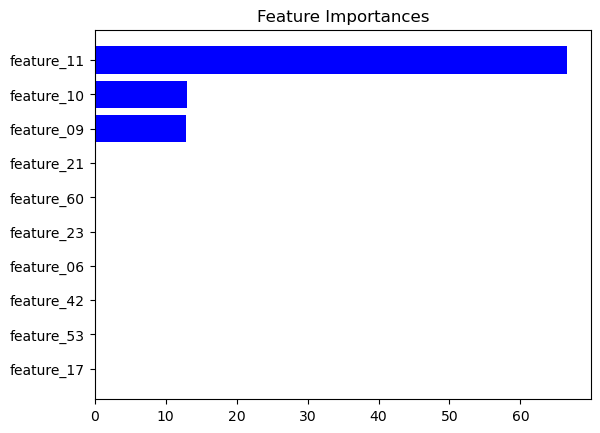

In [8]:
basemodel.feature_importances()

In [9]:
basemodel.save_model(name='Linreg_symbol_38.pkl')

Модель с таким названием уже существует. Измените название файла


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
gradient_boosting = GradientBoostingRegressor(n_estimators=1, learning_rate=0.1, max_depth=3, random_state=42)
basemodel.fit_predict(gradient_boosting)
basemodel.display_metrics()

Model Performance Metrics:
Mean Squared Error: 0.7360
R2 Score: 0.0050
Kaggle R2: 0.0049


In [12]:
basemodel.save_model(name='gradient_boosting_38.pkl')
del symbols_38 # clean data

Модель сохранена в файл: models\gradient_boosting_38.pkl


### partition model


In [13]:
data_preprocess = Preprocess_Data(path_to_data=DATA_PATH)
partition_2 = data_preprocess.get_data(partition_ids=[2]) # для одного partition_id
partition_2.head()

  0%|          | 0/1 [00:00<?, ?it/s]

[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_4.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_6.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_18.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_24.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_27.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\train_symbol_split\\partition_id=2\\symbol_28.parquet'
[Errno 2] No such file or directory: 'c:\\Users\\1\\Desktop\\Study\\magistratura\\kaggle\\data\\

100%|██████████| 1/1 [00:10<00:00, 10.12s/it]


weight  feature_00  feature_01  feature_02  \
date_id time_id symbol_id                                                 
340     0       0          1.902722   -0.523490   -0.131996    0.124154   
        1       0          1.902722    0.461851    0.041478   -0.603966   
        2       0          1.902722   -0.044268    0.450879    0.178004   
        3       0          1.902722   -0.526977    0.980965    0.261958   
        4       0          1.902722    0.127359    1.020979   -0.251529   

                           feature_03  feature_04  feature_05  feature_06  \
date_id time_id symbol_id                                                   
340     0       0           -0.185518    2.011005   -0.665424   -1.030033   
        1       0            0.007258    1.811366   -0.716022   -0.933462   
        2       0           -0.160685    1.954978   -0.966989   -1.516941   
        3       0            0.222629    1.889470   -0.629607   -2.578671   
        4       0            0.037254    2.011796   -1.984879   -5.407247   

                           feature_07  feature_08  ...  feature_78  \
date_id time_id symbol_id                          ...               
340     0       0           -1.528010    0.261375  ...   -0.183416   
        1       0           -1.164065    0.249138  ...   -0.150084   
        2       0           -1.702026    0.185663  ...   -0.167592   
        3       0           -2.773754    0.192884  ...   -0.189944   
        4       0           -3.985164    0.486652  ...   -0.052726   

                           responder_0  responder_1  responder_2  responder_3  \
date_id time_id symbol_id                                                       
340     0       0             0.251685     0.421458     0.771927     0.071990   
        1       0             0.067833     0.478796     0.723186    -0.231785   
        2       0             0.697944     0.559619     1.583761     0.176160   
        3       0            -0.805040    -0.357155    -0.516958    -0.463398   
        4       0             0.227678    -0.139769     0.022477     0.202364   

                           responder_4  responder_5  responder_6  responder_7  \
date_id time_id symbol_id                                                       
340     0       0             1.426416     0.814566    -0.132949     1.183992   
        1       0             1.303077     0.245027    -0.348043     1.166154   
        2       0             1.588704     0.759889    -0.452282     1.225609   
        3       0             0.561400    -1.082378    -0.584636     1.291478   
        4       0             0.984722    -0.458561     0.012878     0.957306   

                           responder_8  
date_id time_id symbol_id               
340     0       0             0.371725  
        1       0            -0.431437  
        2       0            -0.304519  
        3       0            -1.143106  
        4       0            -0.845951  

[5 rows x 89 columns]

In [14]:
basemodel = BaseModelClass(data=partition_2, target_column="responder_6")
linear_model_2 = LinearRegression()
basemodel.fit_predict(linear_model_2)
basemodel.display_metrics()

Model Performance Metrics:
Mean Squared Error: 0.8667
R2 Score: 0.0228
Kaggle R2: 0.0225


In [15]:
basemodel.save_model(name='LinearRegression_partition_2.pkl')

Модель сохранена в файл: models\LinearRegression_partition_2.pkl


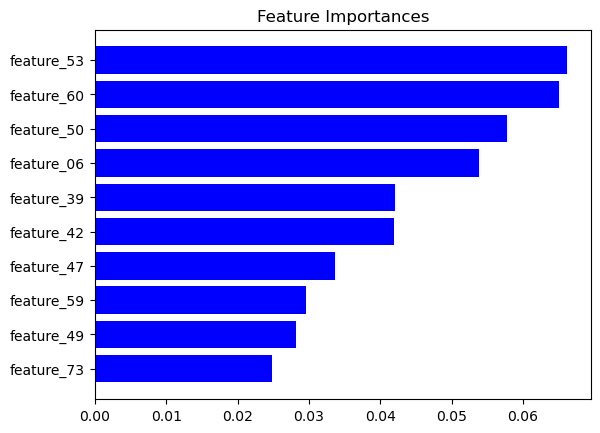

In [16]:
basemodel.feature_importances()